In [2]:
from PIL import Image
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.filters import gaussian
from skimage.measure import label
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes
import json
from pycocotools import mask
from skimage import measure
import cv2
from matplotlib import rcParams


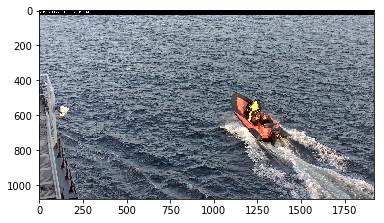

In [3]:
# Read in the image
im = Image.open("images/test_image.jpg")

# Convert image to numpy array
im = np.array(im)

# Display numpy array
plt.imshow(im)

Rows: 320
Cols: 337


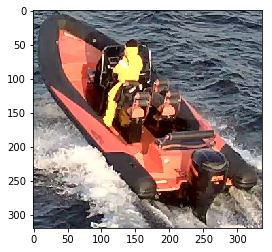

In [4]:
# Read in the image
im = Image.open("images/test_image.jpg")
original_rows, original_cols = im.size

# Declare bounding box
crop_rectangle = (1095, 468, 1432, 788)

# Crop the image around the bounding box
im = im.crop(crop_rectangle)

# Load pixel data from cropped image
pix = im.load()

cols, rows = im.size

print("Rows: {}".format(rows))
print("Cols: {}".format(cols))

# Convert cropped image to numpy array
im = np.array(im)
# im = gaussian(im, sigma=6)
original_shape = im.shape

# Display numpy array
plt.imshow(im)

In [5]:
# Load positive and negative histograms
RGB_Water_Histogram = np.load('histograms/boat_positive_histogram.npy')
RGB_Non_Water_Histogram = np.load('histograms/boat_negative_histogram.npy')

In [6]:
# Get the height and width of the sample image
rows = np.shape(im)[0]
cols = np.shape(im)[1]

print("Rows: {}".format(rows))
print("Cols: {}".format(cols))

# Get histogram bins
histogram_bins = np.shape(RGB_Water_Histogram)[0]

# Get the factor based on the histogram bins
factor = 256 / histogram_bins

Rows: 320
Cols: 337


In [7]:
# Declare a results numpy array that contains only zeros
result = np.zeros((rows, cols))

/Users/brentredmon/Desktop/separatus/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


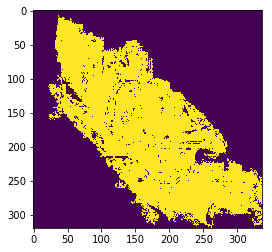

In [8]:
# Determine the probability of water given RGB and histograms representing water and non water

try:
    iterations = 4
    for row in range(rows):
        for col in range(cols):
    #         print(row)
    #         print(col)
    #         print("\n")
            red = float(pix[col, row][0])
            green = float(pix[col, row][1])
            blue = float(pix[col, row][2])

            red_index = floor(red / factor)
            green_index = floor(green / factor)
            blue_index = floor(blue / factor)

            water_value = RGB_Water_Histogram[red_index, green_index, blue_index]
            non_water_value = RGB_Non_Water_Histogram[red_index, green_index, blue_index]

            total = water_value + non_water_value

            if total is not 0:
                result[row, col] = water_value / total


    # Filter out points given threshold

    threshold = 0.48

    for row in range(rows):
        for col in range(cols):
            if result[row, col] < threshold:
                result[row, col] = 1
            else:
                result[row, col] = 0

    plt.imshow(result)

    # Get the largest connected component
    labels = label(result)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1

except:
    iterations = 2
    for row in range(rows):
        for col in range(cols):
    #         print(row)
    #         print(col)
    #         print("\n")
            red = float(pix[col, row][0])
            green = float(pix[col, row][1])
            blue = float(pix[col, row][2])

            red_index = floor(red / factor)
            green_index = floor(green / factor)
            blue_index = floor(blue / factor)

            water_value = RGB_Water_Histogram[red_index, green_index, blue_index]
            non_water_value = RGB_Non_Water_Histogram[red_index, green_index, blue_index]

            total = water_value + non_water_value

            if total is not 0:
                result[row, col] = water_value / total


    # Filter out points given threshold

    threshold = 0.48

    for row in range(rows):
        for col in range(cols):
            if result[row, col] < np.median(result):
                result[row, col] = 1
            else:
                result[row, col] = 0

    plt.imshow(result)

    # Get the largest connected component
    labels = label(result)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1

plt.imshow(largestCC)

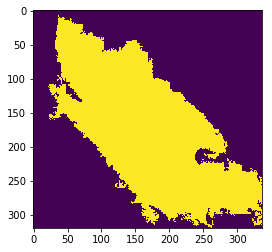

In [9]:
# Fill holes in the boat

largestCC = binary_fill_holes(largestCC)
plt.imshow(largestCC)

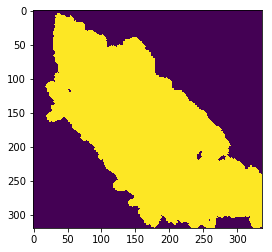

In [10]:
# Dialate to expand the mask

largestCC = binary_dilation(largestCC, iterations=iterations)
plt.imshow(largestCC)

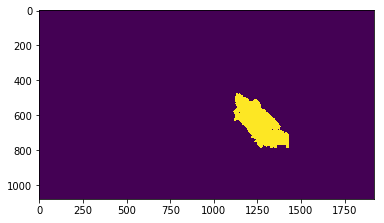

In [11]:
# Create numpy zeros array the same size as the original image before cropping
image_with_mask = np.zeros((original_cols, original_rows))

# Overlay binary mask onto zeros array
image_with_mask[crop_rectangle[1]:crop_rectangle[1] + rows, crop_rectangle[0]:crop_rectangle[0] + cols] = largestCC

plt.imshow(image_with_mask)

In [13]:
# Now that we have the mask, we can convert the mask into COCO JSON format

# Convert mask to type uint8
image_with_mask = np.array(image_with_mask, dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(image_with_mask)
encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
ground_truth_area = mask.area(encoded_ground_truth)
ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
contours = measure.find_contours(image_with_mask, 0.5)

segmentations = list()

for contour in contours:
    contour = np.flip(contour, axis=1)
    segmentation = contour.ravel().tolist()
    segmentations.append(segmentation)
    
print(json.dumps(segmentations, indent=4))

[
    [
        1428.0,
        787.5,
        1427.0,
        787.5,
        1426.0,
        787.5,
        1425.0,
        787.5,
        1424.0,
        787.5,
        1423.0,
        787.5,
        1422.0,
        787.5,
        1421.0,
        787.5,
        1420.0,
        787.5,
        1419.0,
        787.5,
        1418.5,
        787.0,
        1418.0,
        786.5,
        1417.5,
        786.0,
        1417.0,
        785.5,
        1416.5,
        785.0,
        1416.0,
        784.5,
        1415.5,
        784.0,
        1415.5,
        783.0,
        1415.5,
        782.0,
        1415.5,
        781.0,
        1415.5,
        780.0,
        1415.0,
        779.5,
        1414.5,
        779.0,
        1414.0,
        778.5,
        1413.5,
        778.0,
        1413.0,
        777.5,
        1412.5,
        777.0,
        1412.5,
        776.0,
        1412.5,
        775.0,
        1412.5,
        774.0,
        1412.5,
        773.0,
        1413.0,
        772.5,
